In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [3]:
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [14]:
print(df.dtypes)
print(df.isnull().sum())


lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [12]:
categorical = list(df.columns[df.dtypes == object])
numerical = list(df.columns[df.dtypes != object])

In [ ]:
for c in categorical:
    df[c] = df[c].fillna('NA')

for c in numerical:
    df[c] = df[c].fillna(0)


In [15]:
import sklearn

In [16]:
from sklearn.model_selection import train_test_split

In [20]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_full_train, df_train, df_val, df_test = df_full_train.reset_index(drop=True), df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)
y_full_train, y_train, y_val, y_test = df_full_train.converted, df_train.converted, df_val.converted, df_test.converted

In [21]:
from sklearn.metrics import roc_auc_score

In [28]:
numerical


['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [31]:
#Question 1:
for c in numerical: 
    rocc = roc_auc_score(y_train.values, df_train[c].values )
    print('%s  %.3f' % (c, rocc))

number_of_courses_viewed  0.764
annual_income  0.552
interaction_count  0.738
lead_score  0.614
converted  1.000


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [119]:
def train(df, C = 1):
    y = df.converted
    X = df.copy()
    # del X['converted']
    dv = DictVectorizer(sparse=False)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    X = dv.fit_transform(X.to_dict(orient='records'))
    model.fit(X, y)
    return dv, model
def predict_and_score(model, dv, df):
    y = df.converted
    X = df.copy()
    # del X['converted']
    X = dv.transform(X.to_dict(orient = 'records'))
    y_pred = model.predict_proba(X)[:, 1] 
    return roc_auc_score(y, (y_pred> 0.5).astype(int))
def eval_thresholds(model, dv, df):
    y = df.converted
    X = df.copy()
    # del X['converted']
    X = dv.transform(X.to_dict(orient = 'records'))
    preds = pd.DataFrame()
    preds['y'], preds['prob'] = y,  model.predict_proba(X)[:,1]
    scores = pd.DataFrame()
    scores['threshold'] = np.arange(0, 1, 0.01)
    scores['auc'] = [roc_auc_score(y, (preds.prob > th).astype(int)) for th in scores.threshold]
    scores['fp'] = [((~y) & (preds.prob > th)).mean() for th in scores.threshold]
    scores['tp'] = [(y & (preds.prob > th)).mean() for th in scores.threshold]
    scores['fn'] = [(y & (preds.prob <= th)).mean() for th in scores.threshold]
    scores['tn'] = [((~ y) & (preds.prob <= th)).mean() for th in scores.threshold]
    scores['recall'] = scores.tp/(scores.tp + scores.fn)
    scores['percision'] = scores.tp/(scores.tp + scores.fp)
    scores['F1'] = 2 * scores.percision * scores.recall / (scores.percision + scores.recall)
    plt.figure(figsize=(5, 5))
    plt.plot(scores.threshold, scores.percision, label = 'percision')
    plt.plot(scores.threshold, scores.recall, label = 'recall')
    plt.plot(scores.threshold, scores.F1, label = 'F1')

    plt.xlabel('Threshold')
    plt.legend()
    plt.show

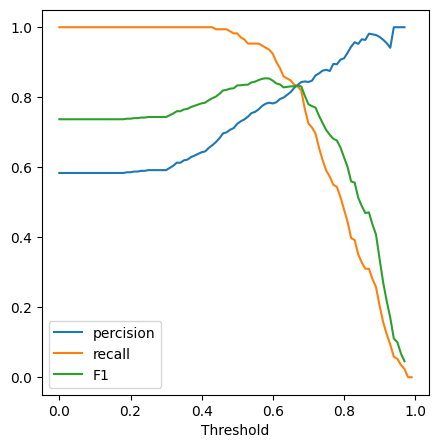

In [107]:
eval_thresholds(m, t, df_val)

In [112]:
from sklearn.model_selection import KFold
print(df_full_train.head())

    lead_source   industry  number_of_courses_viewed  annual_income  \
0      referral         NA                         1        56659.0   
1  social_media  education                         2        66171.0   
2        events    finance                         1        66523.0   
3  social_media    finance                         1        56746.0   
4      referral         NA                         0        55449.0   

  employment_status       location  interaction_count  lead_score  converted  
0          employed           asia                  4        0.75          1  
1        unemployed  north_america                  2        0.66          0  
2     self_employed         europe                  3        0.64          1  
3           student  north_america                  3        0.98          0  
4           student      australia                  4        0.47          0  


In [120]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    X = df_full_train.iloc[train_idx]
    dv,model = train(X)
    scores.append(predict_and_score(model, dv, X))
print(scores)
np.std(scores)


[np.float64(0.7451593119359832), np.float64(0.7412499520282458), np.float64(0.7513528034693173), np.float64(0.7521344127843883), np.float64(0.7423737614123145)]


np.float64(0.004509369007482635)

In [123]:
!pip install tqdm
from tqdm.auto import tqdm

In [124]:
res = []
for C in  tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        X = df_full_train.iloc[train_idx]
        dv,model = train(X, C)
        scores.append(predict_and_score(model, dv, X))
    res.append((- np.mean(scores), np.std(scores), C))

print(sorted(res))

  0%|          | 0/3 [00:00<?, ?it/s]

[(np.float64(-0.7464540483260498), np.float64(0.004509369007482635), 1), (np.float64(-0.5082587057769207), np.float64(0.000846570975662988), 0.001), (np.float64(-0.5002724795640328), np.float64(0.0005449591280654254), 1e-06)]
